<a href="https://colab.research.google.com/github/datascience-dude/DataScience/blob/main/DS_7333_QTW_CaseStudy2_Dawson_Franklin_Herman_Mann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantifying the World:  Case Study 2

### Team:  Christopher Dawson, Bodie Franklin, Kristi Herman, Steven Mann

---


## Table of Contents
* <a href='#bu'>Business Understanding</a>
* <a href='#de'>Data Evaluation/Engineering</a>
* <a href='#model1'>Modeling Preparations</a>
* <a href='#model2'>Model Building and Evaluation</a>
* <a href='#model3'>Model Interpretability and Explainability</a>
* <a href='#conclusions'>Case Conclusions</a>

<a id='bu'></a>
# Business Understanding

A superconductor is a material that conducts electricity with little to no resistance.  A key part of superconductors is the critical temperature, the temperature at which the electrical resistance drops to zero.  <br>

There is a group of scientists who want to create new types of superconductors.  To achieve this, they need a machine learning model to predict the critical temperature of a superconductor based on the composition of its chemical elements and other characteristics such as atomic mass, thermal conductivity, valence, etc.  <br>

The project has two objectives:<br>
<ol><li>Build a model to predict the critical temperature of a superconductor.</li>
<li>Identify the important variables contributing to the predictions.</li></ol>

Linear regression models with L1 and L2 regularization will be utilized to achieve these objectives.<br>

### Import Data

In [21]:
#Mount your Google Drive to pull in and set the wd to it. 
from google.colab import drive
drive.mount('/content/gdrive')
#%cd gdrive/My Drive/DataScience/QuantifyingTheWorld/Week1/CaseStudy1
%cd gdrive/My Drive

Mounted at /content/gdrive
/content/gdrive/My Drive


In [ ]:
# This code will allow you to upload the data directly from your machine to the general Google Drive location.
# Needs file:
#             
# If this is already in your Google Drive, skip this cell
from google.colab import files
uploaded = files.upload()

Saving diabetic_readmissions.csv to diabetic_readmissions.csv


In [27]:
#change this to your directory
%cd DataScience/QuantifyingTheWorld/Week2

/content/gdrive/My Drive/DataScience/QuantifyingTheWorld/Week2


In [29]:
! git clone https://github.com/datascience-dude/DataScience

Cloning into 'DataScience'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 77 (delta 13), reused 65 (delta 8), pack-reused 0
Unpacking objects: 100% (77/77), done.
Checking out files: 100% (58/58), done.


In [30]:
! git pull

There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=<remote>/<branch> master



In [31]:
! git init

Initialized empty Git repository in /content/gdrive/My Drive/DataScience/QuantifyingTheWorld/Week2/.git/


In [32]:
!git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Case Study 2 Data Profiling Report.pdf
	CaseStudy2.html/
	DataScience/
	Files_QTW_Week2.zip
	Files_QTW_Week2/
	IDs_mapping.csv
	dataset_diabetes.zip
	dataset_diabetes/
	diabetic_data.csv
	diabetic_readmissions.csv

nothing added to commit but untracked files present (use "git add" to track)


In [33]:
%ls -a

'Case Study 2 Data Profiling Report.pdf'   diabetic_readmissions.csv
 CaseStudy2.html/                          Files_QTW_Week2/
 DataScience/                              Files_QTW_Week2.zip
 dataset_diabetes/                         .git/
 dataset_diabetes.zip                      IDs_mapping.csv
 diabetic_data.csv


In [ ]:
# Python Packages
modnames = "pandas numpy matplotlib altair seaborn plotly sklearn tensorflow statsmodels sqlite3".split()
for lib in modnames:
    globals()[lib] = __import__(lib)

In [5]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics as mt

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
from rpy2.robjects.packages import importr

In [8]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler, StandardScaler

In [11]:
from sklearn.linear_model import Lasso

In [12]:
from sklearn.model_selection import train_test_split as split #############

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [34]:
#original datasets
df=pd.read_csv("diabetic_readmissions.csv")

In [36]:
#IDMapping for the data set categorical variables
mapping=pd.read_csv("IDs_mapping.csv")

In [37]:
print(df.describe())

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,ReadmittedIn30Days
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607,0.111599
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600,0.314874
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,0.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,1.000000


In [ ]:
#rename critical temp column
print(df.head())

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinolo

In [ ]:
#check all rows duplicated
print(df.duplicated().sum())

0

In [ ]:
print(df.describe(include='all'))

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,ReadmittedFlag
count,1.017660e+05,1.017660e+05,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766,101766,101766,101766.000000,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,6,3,10,10,NaN,NaN,NaN,NaN,18,73,NaN,NaN,NaN,NaN,NaN,NaN,717,749,790,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3,2
top,NaN,NaN,Caucasian,Female,[70-80),?,NaN,NaN,NaN,NaN,?,?,NaN,NaN,NaN,NaN,NaN,NaN,428,276,250,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,N
freq,NaN,NaN,76099,54708,26068,98569,NaN,NaN,NaN,NaN,40256,49949,NaN,NaN,NaN,NaN,NaN,NaN,6862,6752,11555,NaN,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864,96065
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,NaN,NaN,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,NaN,NaN,NaN,7.422607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,NaN,NaN,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,NaN,NaN,NaN,1.933600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,NaN,NaN,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,NaN,NaN,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,NaN,NaN,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# substring to be searched
df['weight'].replace('?','0',inplace=True)
df['weight'].replace('','0',inplace=True)
df['payer_code'].replace('?','',inplace=True)
df['medical_specialty'].replace('?','',inplace=True)

In [ ]:
print(df.describe(include='all'))

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,ReadmittedFlag
count,1.017660e+05,1.017660e+05,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766,101766,101766,101766.000000,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,6,3,10,10,NaN,NaN,NaN,NaN,18,73,NaN,NaN,NaN,NaN,NaN,NaN,717,749,790,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3,2
top,NaN,NaN,Caucasian,Female,[70-80),0,NaN,NaN,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,428,276,250,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,N
freq,NaN,NaN,76099,54708,26068,98569,NaN,NaN,NaN,NaN,40256,49949,NaN,NaN,NaN,NaN,NaN,NaN,6862,6752,11555,NaN,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864,96065
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,NaN,NaN,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,NaN,NaN,NaN,7.422607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,NaN,NaN,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,NaN,NaN,NaN,1.933600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,NaN,NaN,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,NaN,NaN,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,NaN,NaN,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

## Exploratory Data Analysis

Load the data into R and print the DataTable.

In [ ]:
# Bring df into R
%R -i df

In [ ]:
# What are the current data types and overall view of the table?
%%R
skim(df)

   skim_type            skim_variable n_missing complete_rate character.min
1  character                     race         0             1             1
2  character                   gender         0             1             4
3  character                      age         0             1             6
4  character                   weight         0             1             1
5  character               payer_code         0             1             1
6  character        medical_specialty         0             1             1
7  character                   diag_1         0             1             1
8  character                   diag_2         0             1             1
9  character                   diag_3         0             1             1
10 character            max_glu_serum         0             1             4
11 character                A1Cresult         0             1             2
12 character                metformin         0             1             2
13 character

In [ ]:
%%R
introduce(df)

    rows columns discrete_columns continuous_columns all_missing_columns
1 101766      51               38                 13                   0
  total_missing_values complete_rows total_observations memory_usage
1                    0        101766            5190066     36379400


In [ ]:
# What are the current data types and overall view of the table?
%%R
summary(df)

  encounter_id        patient_nbr            race              gender         
 Min.   :    12522   Min.   :      135   Length:101766      Length:101766     
 1st Qu.: 84961194   1st Qu.: 23413221   Class :character   Class :character  
 Median :152388987   Median : 45505143   Mode  :character   Mode  :character  
 Mean   :165201646   Mean   : 54330401                                        
 3rd Qu.:230270888   3rd Qu.: 87545950                                        
 Max.   :443867222   Max.   :189502619                                        
     age               weight          admission_type_id
 Length:101766      Length:101766      Min.   :1.000    
 Class :character   Class :character   1st Qu.:1.000    
 Mode  :character   Mode  :character   Median :1.000    
                                       Mean   :2.024    
                                       3rd Qu.:3.000    
                                       Max.   :8.000    
 discharge_disposition_id admission_source_id ti

In [ ]:
%%R
install.packages("htmltools")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/htmltools_0.5.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 124510 bytes (121 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [ ]:
%%capture
#%%R
#create_report(df,output_file = "CaseStudy2.html",output_dir = 'CaseStudy2.html', y = 'ReadmittedFlag')
#link to html output: https://drive.google.com/file/d/1-bTXsl_wZbB9mPvGEbRxBxUsS1MGK1p-/view?usp=sharing  
##Download the file due to > 3MB

R[write to console]: 4 features with more than 20 categories ignored!
medical_specialty: 73 categories
diag_1: 717 categories
diag_2: 749 categories
diag_3: 790 categories




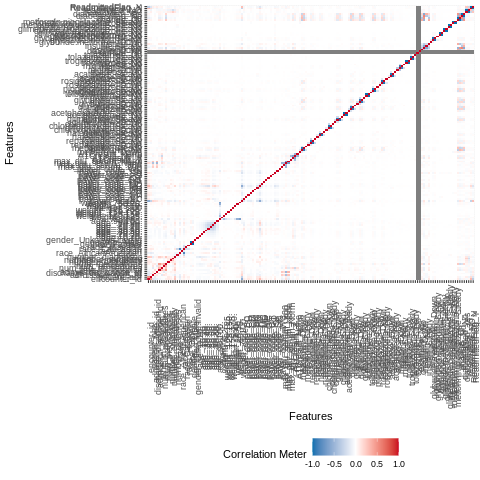

In [ ]:
%%R
plot_correlation(df)

R[write to console]: 8 features with more than 5 categories ignored!
race: 6 categories
age: 10 categories
weight: 10 categories
payer_code: 18 categories
medical_specialty: 73 categories
diag_1: 717 categories
diag_2: 749 categories
diag_3: 790 categories




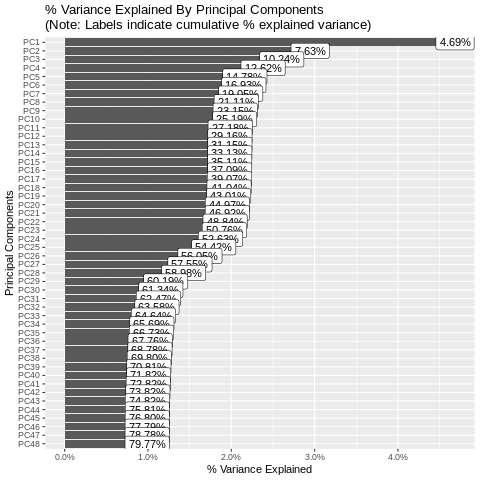

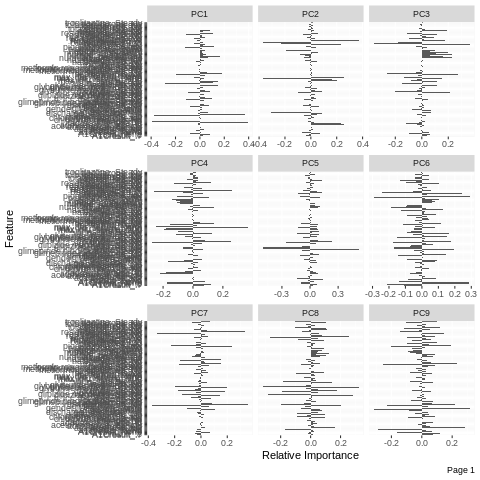

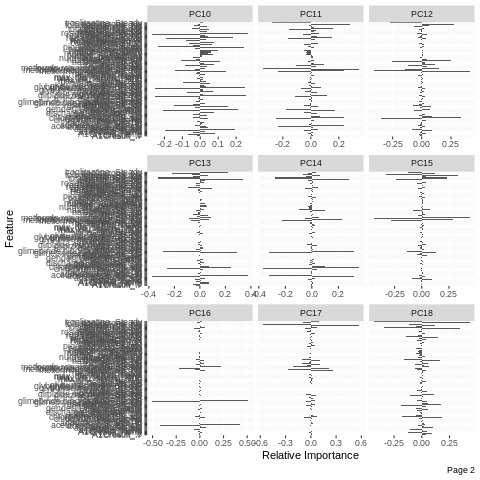

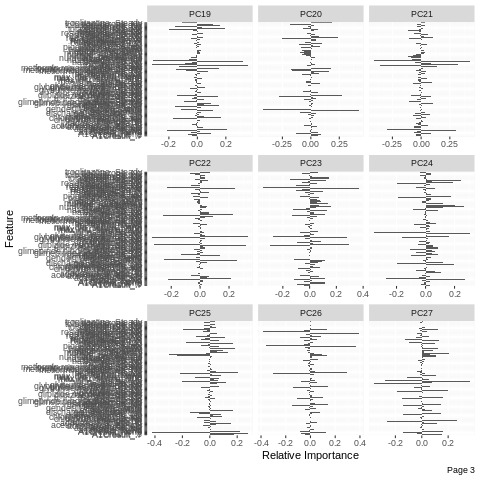

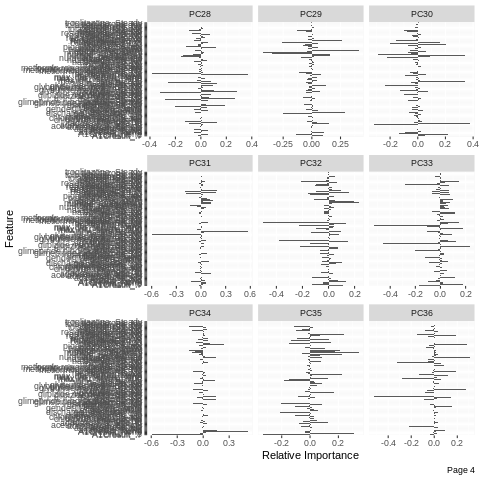

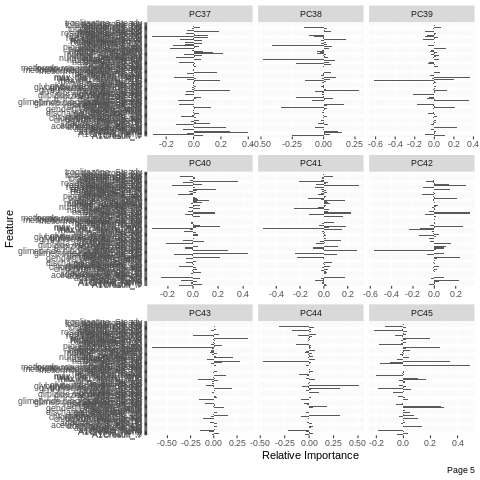

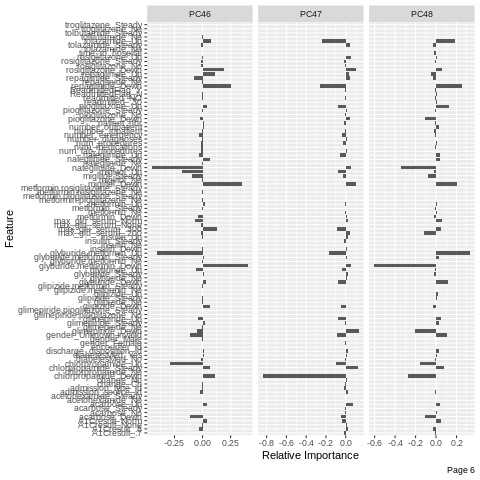

In [ ]:
%%R
plot_prcomp(df, maxcat = 5L)

In [ ]:
numeric_columns = df.columns[df.dtypes != 'object']
string_columns = df.columns[df.dtypes == 'object']
print(f'There are {len(numeric_columns)} numeric columns & {len(string_columns)} string columns')

There are 13 numeric columns & 38 string columns


<a id='de'></a>
# Data Evaluation/Engineering

The source data for this project contains information for superconductors including superconductor materials, chemical characteristics, and the critical temperature.  Two datasets were provided, train.csv and unique_m.csv, with instructions that the index value in each file represents the same superconductor.   <br><br>

After combining the files based on index, the complete dataset contains 169 columns and 21,263 observations.  There are no duplicate rows or missing data.  All columns contain continuous values except for the "material" column which contains discrete values. The values in the "material" column are not entirely unique with ~5700 duplicates.  There are no duplicate rows in the dataset so any row with a duplicate "material" value is assumed to be an independent observation.  The "material" column was not included in the models.   With the high number of unique values we don't expect it to significantly contribute to predictions.<br><br>

The table and plots below show basic statistics for the complete dataset.


The critical temperature is the target response variable and ranges from 0.0002 to 185 with a mean of 34.42.  Although the unit of measurement is not explicitly stated in the source data it is assumed to be degrees Kelvin as superconductors are normally measured in this scale. <br><br>The summary statistics and histogram for critical temperature are shown below.

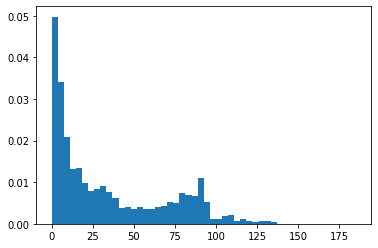

In [ ]:
#histogram of critical temperatures
fig, ax = plt.subplots()
num_bins = 50
n, bins, patches = ax.hist(df['critical_temp'], num_bins, density=True)
plt.show()

Except for the "material" column, all variables will be used in the models. The variables with the highest linear correlation to critical temperature are wtd_std_ThermalConductivity, range_ThermalConductivity, range_atomic_radius, std_ThermalConductivity, and wtd_mean_Valence. 

In [ ]:
numeric_df = pd.DataFrame(data=df_merged, columns=numeric_columns, index=df_merged.index)
corr = np.abs(numeric_df.corr())
series = np.abs(corr['critical_temp']).sort_values(ascending=False)
print('The most linear correlated features to critical_temp are:')
for i, row in enumerate(series):
    if 0.2 <= row < 1:
      print(f'{series.index[i]:17} --> {row: .2f} (abs)')

The most linear correlated features to critical_temp are:
wtd_std_ThermalConductivity -->  0.72 (abs)
range_ThermalConductivity -->  0.69 (abs)
range_atomic_radius -->  0.65 (abs)
std_ThermalConductivity -->  0.65 (abs)
wtd_mean_Valence  -->  0.63 (abs)
wtd_entropy_atomic_mass -->  0.63 (abs)
wtd_gmean_Valence -->  0.62 (abs)
wtd_entropy_atomic_radius -->  0.60 (abs)
number_of_elements -->  0.60 (abs)
range_fie         -->  0.60 (abs)
mean_Valence      -->  0.60 (abs)
wtd_std_atomic_radius -->  0.60 (abs)
entropy_Valence   -->  0.60 (abs)
wtd_entropy_Valence -->  0.59 (abs)
wtd_std_fie       -->  0.58 (abs)
gmean_Valence     -->  0.57 (abs)
entropy_fie       -->  0.57 (abs)
O                 -->  0.57 (abs)
wtd_entropy_FusionHeat -->  0.56 (abs)
std_atomic_radius -->  0.56 (abs)
entropy_atomic_radius -->  0.56 (abs)
Ba                -->  0.56 (abs)
entropy_FusionHeat -->  0.55 (abs)
entropy_atomic_mass -->  0.54 (abs)
std_fie           -->  0.54 (abs)
gmean_Density     -->  0.54 (abs)

There are many columns in the dataset that seem like variations of the same measurement.  For example, there are ten variables related to atomic mass:  mean_atomic_mass, wtd_mean_atomic_mass, gmean_atomic_mass, entropy_atomic_mass, etc. The variance inflation factor for these variables is also high, which is further evidence that these are correlated variables.  Without a deeper understanding of the underlying data, our approach is to include all variables and allow regularization and Recursive Feature Elimination (RFE) to determine which variables are most important.   <br><br>
The correlation plot and VIF table below show the high correlation between features, e.g., wtd_gmean_atomic_mass and entropy_atomic mass.

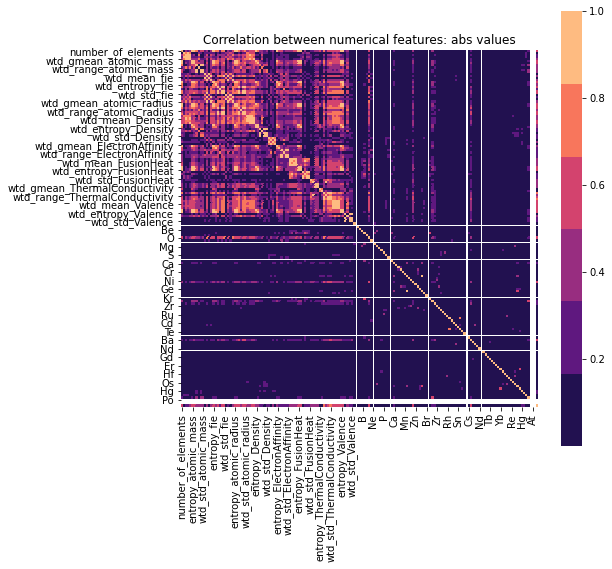

In [ ]:
# Numeric Heatmap
# numeric_df = pd.DataFrame(data=df_merged, columns=numeric_columns, index=df_merged.index)
# corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sns.color_palette("magma")
sns.heatmap(corr, cmap=cmap, square=True)
plt.title('Correlation between numerical features: abs values')
plt.show()

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i)
                           for i in range(len(numeric_df.columns))]
print(vif_data)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1638: RuntimeWarning:

invalid value encountered in double_scalars



                             feature            VIF
0                 number_of_elements     801.819955
1                   mean_atomic_mass    4352.155466
2               wtd_mean_atomic_mass    5158.110922
3                  gmean_atomic_mass    2979.218981
4              wtd_gmean_atomic_mass    3386.415678
5                entropy_atomic_mass    2535.798162
6            wtd_entropy_atomic_mass    1350.954042
7                  range_atomic_mass     351.912835
8              wtd_range_atomic_mass      65.355117
9                    std_atomic_mass     711.680414
10               wtd_std_atomic_mass     487.263866
11                          mean_fie  199212.704178
12                      wtd_mean_fie  366438.061273
13                         gmean_fie  178267.427992
14                     wtd_gmean_fie  327532.026324
15                       entropy_fie   61740.631339
16                   wtd_entropy_fie    1800.413412
17                         range_fie    1393.867321
18          

Some variables in the dataset do not meet the normal distribution requirement for linear regression models.  Below are a few examples.  Transformations will not be applied for this analysis, but could be used in future analysis to improve model performance. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8e4cdc950>,
      dtype=object)

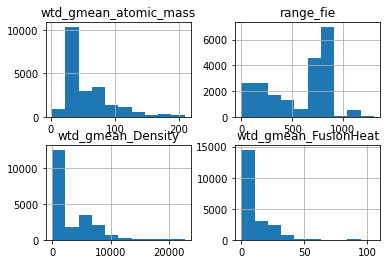

In [ ]:
#sample of variables with skewed distributions
numeric_df.hist(column=['wtd_gmean_atomic_mass','range_fie','wtd_gmean_Density','wtd_gmean_FusionHeat'])

<a id='model1'></a>
# Modeling Preparations

<a id='model2'></a>
# Model Building and Evaluations

<a id='model3'></a>
# Model Interpretability and Explainability

<a id='conclusions'></a>

Each model produced a different set of important variables.  Rather than selecting one set of results based on the best model metrics, the top results from each model and method are listed below for further evaluation by the scientists with subject matter expertise on superconductors.  For the first two rows, the number shown with the variable is the absolute value of the coefficient where a higher value indicates a higher importance.  <br><br>

Given the lack of the business subject-matter knowledge we are left to glean most from the statistical findings led by the Ridge model with 67.5% explained variance in the model and root-mean squared error (RMSE) of 19.598. While both models provide penalties and 10-fold cross-validation, LASSO brought lesser significant variables to 0.00 Coefficient values. Across both models the most important features involved entropy & cations (2+ to 5+) of mid-range atomic numbers. <br><br>

Further SME knowledge would provide context for variable importance, including more complex modeling for this sparse dataset, using elasticnet regression, which performs well with highly correlated variables, or Random Forest regression which doesn't require normally distributed variables.  All are possible solutions for improving model performance. 


|<p>Model/Method|<p>Top Features|
|:-----|:-----|
|<p>LASSO - Top 10 Features based on Coefficients|<p>wtd_entropy_atomic_mass (9.05), Ba (8.5), wtd_std_Valence (6.09), Hg (5.76), Ca (3.67), Bi (3.57), Tl (2.56), Ce (1.88), Sr (1.44), Si (0.94)|
|<p>Ridge - Top 10 Features based on Coefficients|<p>entropy_atomic_radius (64.75), entropy_Valence (40.3), wtd_entropy_fie (35.16), entropy_fie (34.34), wtd_std_Valence (33.05), wtd_entropy_atomic_mass (26.57),<br> wtd_gmean_Valence (26.16), wtd_mean_Valence (24.45), entropy_atomic_mass (19.61), wtd_entropy_ElectronAffinity (18.17)|
|<p>LASSO - Top Features based on RFE|<p>Mo, Tc, Ru, Rh, Pd, Ag, Cd, In, Sn, Sb, Te, I, Xe, Cs, Ba, La, Ce, Pr, Nd, Pm, Sm, Eu, Gd, Tb, Dy, Ho, Er, Tm, Yb, Lu, Hf, Ta, W, Re, Os, Ir, Pt, Au, Hg, Tl, Pb, Bi, Po, At, Rn|
|<p>Ridge - Top Features based on RFE|<p>entropy_atomic_mass, wtd_entropy_atomic_mass, entropy_fie, wtd_entropy_fie, entropy_atomic_radius, <br>wtd_entropy_atomic_radius, entropy_ElectronAffinity, wtd_entropy_ElectronAffinity, entropy_FusionHeat, wtd_entropy_FusionHeat, <br>wtd_entropy_ThermalConductivity, mean_Valence, wtd_mean_Valence, gmean_Valence, wtd_gmean_Valence, <br>entropy_Valence, wtd_entropy_Valence, std_Valence, wtd_std_Valence, H, Li, Na, Cl, Ca, Sc, Fe, Cu, Br, Rb, Sr, Y,<br> Tc, Ag, Cs, Ba, Ce, Nd, Sm, Eu, Ho, Lu, Pt, Hg, Tl, Bi|

<a id='conclusions'></a>
# Case Conclusions

<a id='model3'></a>
Below are the final results from the LASSO L1 regularization and Ridge L2 regularization linear regression models.  <br>

In [ ]:
%%html
<style>
table {float:left}
</style>

|<p>Model|<p>RMSE|<p>R2|
|:-----|:-----|:-----|
|<p>LASSO baseline|<p>34.371|<p>-0.0001|
|<p>LASSO with parameter tuning|<p>21.954|<p>0.578|
|<p>LASSO with parameter tuning and RFE|<p>34.371|<p>-0.0001|
|<p>Ridge baseline|<p>22.150|<p>0.572|
|<p><b>Ridge with parameter tuning and RFE</b>|<p><b>19.598</b>|<p><b>0.675</b>|

Of all the models tested and tuned in this analysis, the Ridge model (L2 regularization) is the recommended linear regression model based on the evaluation metrics. This model has the best performance metrics with tuned parameters and features selected from RFE; the average RMSE is 19.598 and R2 is 0.675.  An RMSE of 19.598 means that on average the error rate of predicting the critical temperature is 19.598 degrees. An R2 of 0.675 indicates that 67.5% of the variance observed can be explained by the model. The Ridge model has a slightly better performance than the best LASSO model which had an RMSE of 21.954 and R2 of 0.578. <br><br>

If there is a desire to improve upon these metrics, other approaches can be explored.  There were variables in the model that had skewed distributions, which can significantly impact linear regression models.  Transformations could be applied to these variables.  Another approach is to use a non-parametric model like Random Forest regression to see if it achieves better results.  With non-parametric models, normal distribution of the variables is not a requirement.  Elasticnet regression is another option as it performs well with highly correlated variables.   